In [9]:
import os
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from time import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split

from neural_network import Neural_Network
from sklearn.model_selection import StratifiedKFold

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from mlxtend.plotting import plot_confusion_matrix as plot_confusion_matrix_2

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers

# Methods to extract and handle data

In [10]:
def load_file(file_name):
    """
    Load .csv file using pd.read_csv
    :param file_name: string containing the file name
    :return: extracted and stripped data in the DataFrame type
    """

    file_dir = os.path.realpath('./')
    for root, dirs, files in os.walk(file_dir):
        for name in files:
            if name == file_name:
                file_path = os.path.join(root, name)

    #load the wanted file using pd.read_csv
    loaded_data = pd.read_csv(file_path)

    #remove blank columns
    data_columns = list(loaded_data)
    for col in data_columns:
        if 'Unnamed' not in col:
            last_col_idx = data_columns.index(col)
    data_stripped = loaded_data.iloc[:, :last_col_idx + 1]

    return data_stripped

def format_data(training_file_name,test_file_name,additional_file_name=None):
    """
    Format the loaded training and test data. Date column is formatted. Columns with categorical features are converted
    to multiple columns with the binary format.
    :param training_file_name: string containing the training file name
    :param test_file_name: string containing the test file name
    :return: formatted training and test data in the DataFrame type
    """

    #load training and test files
    training_data_stripped = load_file(training_file_name)
    test_data_stripped = load_file(test_file_name)
    if additional_file_name is not None:
        additional_file_data_stripped = load_file(additional_file_name)
        all_training_data = pd.concat([training_data_stripped,
                                       additional_file_data_stripped], sort=False, ignore_index=True)
    else:
        all_training_data = training_data_stripped

    all_training_data['FTR'] = all_training_data['FTR'].map({'H': 1, 'D': 2, 'A': 3})
    all_training_data['HTR'] = all_training_data['HTR'].map({'H': 1, 'D': 2, 'A': 3})

    #convert all columns categorical features into multiple columns with the binary format
    #training and test data are combined
    training_and_test_binary = pd.get_dummies(pd.concat([all_training_data.drop(columns=['Date']),
                                                         test_data_stripped.drop(columns=['Date'])], sort=False))

    #extract the training data
    training_binary = training_and_test_binary.iloc[:len(all_training_data),:]

    #extract the test data
    test_binary = training_and_test_binary.iloc[len(all_training_data):,:]
    test_binary_columns = [col for col in training_and_test_binary
                           for original_col in list(test_data_stripped) if col.startswith(original_col)]
    test_binary = test_binary[test_binary_columns]


    #format the Date column
    training_date_formatted = pd.DataFrame(pd.to_datetime(all_training_data.iloc[:,0]))
    test_date_formatted = pd.DataFrame(pd.to_datetime(test_data_stripped.iloc[:,0]))

    #combine the Date column with the rest
    training_data_formatted = pd.concat([training_date_formatted, training_binary], axis=1)
    test_data_formatted = pd.concat([test_date_formatted, test_binary], axis=1)

    return training_data_formatted, test_data_formatted

def get_twenty_latest_team_matches(team_name, data_frame, row_idx):
    """
    Find the latest twenty matches for the specified team.
    -> If the specified row index for the current match is not included
       in the row indices of all the matches, the latest 20 matches of
       all the matches would be returned
    -> If the number of previous matches
       is less than 20, the method would return all previous matches.

    :param team_name: specified team name (e.g. 'HomeTeam_Arsenal', 'AwayTeam_Cardiff', etc.)
    :param data_frame: DataFrame containing all the matches for all the teams
    :param row_index: row index of the current match of interest
    :return: DataFrame with the latest 20 matches
    """

    row_idx_list = []
    for row in range(data_frame.shape[0]):
        if data_frame.loc[row, team_name] == 1:
            row_idx_list.append(row)

    if row_idx not in row_idx_list:
        twenty_matches_row_idx_list = row_idx_list[len(row_idx_list)-20:]
    else:
        number_of_previous_matches = len(row_idx_list[:row_idx_list.index(row_idx)])
        if number_of_previous_matches < 20:
            twenty_matches_row_idx_list = row_idx_list[:row_idx_list.index(row_idx)]
        else:
            twenty_matches_row_idx_list = row_idx_list[row_idx_list.index(row_idx)-20:row_idx_list.index(row_idx)]

    return data_frame.iloc[twenty_matches_row_idx_list]

def non_shot_feature_selection(training_data, team_ratings_data):
    """
    Select features that have correlation values above the defined threshold.

    :param training_data: DataFrame containing the training data
    :param team_ratings_data: Data containing the ratings of the home and away teams at each match
    :return: an array containing names of the selected feature
    """

    data = pd.concat([training_data, team_ratings_data], axis=1, ignore_index=False)
    column_heads_to_drop = ['HomeTeam', 'AwayTeam', 'Date', 'Referee', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS',
                            'HST', 'AST','HTR']
    all_columns_to_drop = [col for col in data
                           for chosen_col in column_heads_to_drop if col.startswith(chosen_col)]

    data = data.drop(columns=all_columns_to_drop)

    corrmat = data.corr()
    FTR_corr = corrmat.loc['FTR'].abs().drop('FTR')
    feature_corr_thershold = 0.05
    selected_features_idx = [row for row in range(FTR_corr.shape[0]) if FTR_corr[row] >= feature_corr_thershold]
    selected_features = FTR_corr[selected_features_idx].index.values

    return selected_features

def extract_test_data(test_data, selected_features, ratings_data, ratings_history):
    """
    Extract the test data is the desired format.
    """
    test_result = pd.DataFrame(columns=[selected_features])
    team_list_h = [col for col in test_data
                               if col.startswith('HomeTeam')]
    team_list_a = [col for col in test_data
                               if col.startswith('AwayTeam')]
    h_list = [col for col in selected_features if col.startswith('H')]
    a_list = [col for col in selected_features if col.startswith('A')]
    for i in range(len(test_data)):
        test = pd.DataFrame(columns=[selected_features])
        for team in team_list_h:
            if test_data.loc[i, team] == 1:
                print(team)
                home_team_twenty_results = get_twenty_latest_team_matches(
                    team, pd.concat([data, ratings_data], axis=1), -1)
                home_team_twenty_results = home_team_twenty_results[h_list]
                for name in h_list:
                    if name == 'HomeRatings':
                        team_used = team.replace('HomeTeam_', '')
                        print(team_used)
                        idx = ratings_history[ratings_history['Team']
                                              == team_used].index.values
                        print(idx)
                        test.loc[i, name] = ratings_history.loc[idx[0], 'Ratings']
                    else:
                        test.loc[i, name] = home_team_twenty_results[name].mean()
        for team in team_list_a:
            if test_data.loc[i, team] == 1:
                away_team_twenty_results = get_twenty_latest_team_matches(
                    team, pd.concat([data, ratings_data], axis=1), -1)
                away_team_twenty_results = away_team_twenty_results[a_list]
                for name in a_list:
                    if name == 'AwayRatings':
                        team_used = team.replace('AwayTeam_', '')
                        idx = ratings_history[ratings_history['Team']
                                              == team_used].index.values
                        test.loc[i, name] = ratings_history.loc[idx[0], 'Ratings']
                    else:
                        test.loc[i, name] = away_team_twenty_results[name].mean()
        test_result = test_result.append(test)
    return test_result

def to_result(data):
    result = []
    for i in range(len(data)):
        d_max = np.amax(data[i])
        if data[i][0] == d_max:
            result.append(1)
        elif data[i][1] == d_max:
            result.append(2)
        else:
            result.append(3)
    return result

# Class Ratings to calculate team ELO ratings

In [11]:
class Ratings:
    """
    A class designed to calculate the ELO ratings for each team after each match.
    """
    def __init__(self, X):
        self.home_team_list = [col for col in X
                        if col.startswith('HomeTeam')]
        h_team_used = []
        team_used = []
        for team in self.home_team_list:
            row_idx_list = []
            for row in range(X.shape[0]):
                if X.loc[row, team] == 1:
                    row_idx_list.append(row)

            if len(row_idx_list) == 0:
                print('Data for {} is EMPTY'.format(team))
                continue
            h_team_used.append(team)
            team_used.append(team.replace('HomeTeam_', ''))

        self.home_team_list = h_team_used
        self.team_list = team_used
        self.away_team_list = [col for col in X
                        if col.startswith('AwayTeam')]
        a_team_used = []
        for team in self.away_team_list:
            row_idx_list = []
            for row in range(X.shape[0]):
                if X.loc[row, team] == 1:
                    row_idx_list.append(row)

            if len(row_idx_list) == 0:
                print('Data for {} is EMPTY'.format(team))
                continue

            a_team_used.append(team)
        self.away_team_list = a_team_used
        self.rating = self.initialize()
        print(self.rating)
        self.result = self.update_ratings(X)
        print(self.result)

    def initialize(self):
        ratings = pd.DataFrame(
            {'Team': self.team_list})
        ratings['Ratings'] = 1500
        return ratings

    def update_ratings(self, X):
        match_ratings = pd.DataFrame(columns=['HomeRatings', 'AwayRatings'])
        for i in range(len(X)):
            rating_h_team = 0
            rating_a_team = 0
            for team_h in self.home_team_list:
                for team_a in self.away_team_list:
                    if X.loc[i, team_h] == 1 and X.loc[i, team_a] == 1:
                        rating_h_team = self.rating[self.rating['Team'].isin(
                            [team_h.replace('HomeTeam_', '')])].index.values
                        rating_h_team = rating_h_team[0]
                        rating_a_team = self.rating[self.rating['Team'].isin(
                            [team_a.replace('AwayTeam_', '')])].index.values
                        rating_a_team = rating_a_team[0]
            add_data = pd.Series(
                {'HomeRatings': self.rating.loc[rating_h_team, 'Ratings'], 'AwayRatings': self.rating.loc[rating_a_team, 'Ratings']})
            match_ratings = match_ratings.append(add_data, ignore_index=True)
            expect_h = self.compute_score(
                self.rating.loc[rating_h_team, 'Ratings'], self.rating.loc[rating_a_team, 'Ratings'])
            expect_a = self.compute_score(
                self.rating.loc[rating_a_team, 'Ratings'], self.rating.loc[rating_h_team, 'Ratings'])

            if X.loc[i, 'FTR'] == 1:
                adjust_h = 1
                adjust_a = 0
            elif X.loc[i, 'FTR'] == 3:
                adjust_h = 0
                adjust_a = 1
            elif X.loc[i, 'FTR'] == 2:
                adjust_h = 0.5
                adjust_a = 0.5
            self.rating.loc[rating_h_team, 'Ratings'] = self.rating.loc[rating_h_team, 'Ratings'] + \
                self.compute_k(
                    self.rating.loc[rating_h_team, 'Ratings']) * (adjust_h - expect_h)
            self.rating.loc[rating_a_team, 'Ratings'] = self.rating.loc[rating_a_team, 'Ratings'] + \
                self.compute_k(
                    self.rating.loc[rating_a_team, 'Ratings']) * (adjust_a - expect_a)
        return match_ratings

    def compute_k(self, rating):
        if rating >= 2400:
            return 15
        elif rating >= 2100:
            return 20
        else:
            return 25

    def compute_score(self, rating1, rating2):
        return 1 / (1+pow(10, (rating2 - rating1) / 400))

In [ ]:
class Data:
    """
    A class designed to structure the X and y data
    """
    def __init__(self, X, y):
        self.X_all = X
        self.y_all = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=100)

class Compare:
    """
    A class that will find the best classification model for the problem. For each classification model
    type, its hyper-parameters will be fine tuned first. Their accuracies are then compared and the most accurate 
    model is selected.
    """
    def __init__(self, X, y):
        self.accuracies = pd.DataFrame(columns=['Models', 'Accuracies'])
        self.data = Data(X, y)
        self.best_models = []
        self.best_idx = self.get_best_idx()
        self.best_model = self.get_best_model()

    def update_accuracies(self, model_name, accuracy):
        add_data = pd.Series({'Models': model_name, 'Accuracies': accuracy})
        self.accuracies = self.accuracies.append(add_data, ignore_index=True)

    def classifier_train(self, classifier, X, y):
        start = time()
        classifier.fit(X, y)
        end = time()
        print("Training time: {}".format(end - start))

    def classifier_score(self, classifier, X, y):
        y_pred = classifier.predict(X)
        return f1_score(y, y_pred, pos_label=1, average='macro'), sum(y == y_pred) / float(len(y_pred))

    def print_result(self, f1, acc, label):
        print("==================================")
        print("Result on the " + label + " set")
        print("F1 score value: " + str(f1))
        print("Accuracy: " + str(acc))
        print("==================================\n")

    def get_cross_val_score(self, classifier, name, X, y):
        start = time()
        scores = cross_val_score(classifier, X, y, cv=5)
        self.update_accuracies(name, sum(scores)/5)
        print("==================================")
        print("Mean of cross-validated scores for testing set:", sum(scores)/5)
        print("The standard deviation of the scores", np.std(scores))
        end = time()
        print("Evaluating time {:}".format(end - start))

    def plot_confusion(self, classifier, class_names, X_test, y_test, title):
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize='true')
        disp.ax_.set_title(title)
        plt.show()

    def tryLR(self):
        # defining parameter range
        param_grid = {'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

        grid = GridSearchCV(LogisticRegression(multi_class="ovr", solver="sag",
                                               max_iter=4000),
                                               param_grid,
                                               refit=True, verbose=2, cv=5)

        start = time()
        # fitting the model for grid search
        grid.fit(self.data.X_all, self.data.y_all)
        # print best parameter after tuning
        print(grid.best_params_)
        # print how our model looks after hyper-parameter tuning
        lr = grid.best_estimator_
        self.best_models.append(lr)
        end = time()
        print(end - start)

        self.classifier_train(lr, self.data.X_train, self.data.y_train)
        f1, acc = self.classifier_score(lr, self.data.X_test, self.data.y_test)
        self.print_result(f1, acc, 'testing')
        f1, acc = self.classifier_score(lr, self.data.X_train, self.data.y_train)
        self.print_result(f1, acc, 'training')

        self.get_cross_val_score(lr, 'Logistic Regression', self.data.X_all, self.data.y_all)

        class_name = ['A', 'D', 'H']
        title = "Confusion matrix with normalization"
        self.plot_confusion(lr, class_name, self.data.X_test, self.data.y_test, title)

    def trySVM(self):
        # defining parameter range
        param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
                      'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                      'kernel': ['linear', 'rbf', 'sigmoid']}

        grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=5)

        # fitting the model for grid search
        grid.fit(self.data.X_all, self.data.y_all)
        # print best parameter after tuning
        print(grid.best_params_)
        # print how our model looks after hyper-parameter tuning
        gsvm = grid.best_estimator_
        self.best_models.append(gsvm)

        self.classifier_train(gsvm, self.data.X_train, self.data.y_train)
        f1, acc = self.classifier_score(gsvm, self.data.X_test, self.data.y_test)
        self.print_result(f1, acc, 'testing')
        f1, acc = self.classifier_score(
            gsvm, self.data.X_train, self.data.y_train)
        self.print_result(f1, acc, 'training')

        self.get_cross_val_score(
            gsvm, 'Support Vector Machine', self.data.X_all, self.data.y_all)

        class_name = ['A', 'D', 'H']
        title = "Confusion matrix with normalization"
        self.plot_confusion(gsvm, class_name, self.data.X_test,
                            self.data.y_test, title)
        
    def tryGNB(self):
        gnb = GaussianNB()
        self.best_models.append(gnb)
        self.classifier_train(gnb, self.data.X_train, self.data.y_train)
        f1, acc = self.classifier_score(
            gnb, self.data.X_test, self.data.y_test)
        self.print_result(f1, acc, 'testing')
        f1, acc = self.classifier_score(
            gnb, self.data.X_train, self.data.y_train)
        self.print_result(f1, acc, 'training')

        self.get_cross_val_score(
            gnb, 'Guassian Naive Bayesian', self.data.X_all, self.data.y_all)

    def trykNN(self):
        param_grid = {'n_neighbors': range(1,101)}

        grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit=True, verbose=2, cv=5)

        # fitting the model for grid search
        grid.fit(self.data.X_all, self.data.y_all)
        # print best parameter after tuning
        print(grid.best_params_)
        # print how our model looks after hyper-parameter tuning
        knn = grid.best_estimator_
        self.best_models.append(knn)
        # knn = KNeighborsClassifier()
        # self.best_models.append(knn)

        self.classifier_train(knn, self.data.X_train, self.data.y_train)
        f1, acc = self.classifier_score(
            knn, self.data.X_test, self.data.y_test)
        self.print_result(f1, acc, 'testing')
        f1, acc = self.classifier_score(
            knn, self.data.X_train, self.data.y_train)
        self.print_result(f1, acc, 'training')

        self.get_cross_val_score(
            knn, 'k-Nearest Neighbor', self.data.X_all, self.data.y_all)
    
    def tryNN(self):
        def to_result(data):
            result = []
            for i in range(len(data)):
                d_max = np.amax(data[i])
                if data[i][0] == d_max:
                    result.append(1)
                elif data[i][1] == d_max:
                    result.append(2)
                else:
                    result.append(3)
            return result
        
        X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(self.data.X_all, self.data.y_all,
                                                                test_size=0.2,
                                                                random_state=100)
        nn = Neural_Network(self.data.X_all.shape[1], len(self.data.y_all.unique()))
        es = EarlyStopping(monitor='val_accuracy',
                           mode='max', verbose=1, patience=50)
        train = nn.model.fit(X_train_1, to_categorical(y_train_1)[:, [1, 2, 3]], batch_size=64,
                                  epochs=500, verbose=0,
                             validation_data=(X_test_1, to_categorical(y_test_1)[:, [1, 2, 3]]), callbacks=[es])
        print(train.history.keys())
        result = nn.model.evaluate(
            self.data.X_test, to_categorical(self.data.y_test)[:, [1, 2, 3]])
        print("==================================")
        print("Result on the testing set")
        print("F1 score value: " + str(result[1] * 100))
        print("Accuracy: " + str(result[2]))
        print("==================================\n")

        plt.plot(train.history['accuracy'])
        plt.plot(train.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')
        plt.show()
        # summarize history for loss
        plt.plot(train.history['loss'])
        plt.plot(train.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

        y_pred = nn.model.predict(self.data.X_test)
        nn_cm = confusion_matrix(
            self.data.y_test, to_result(y_pred), labels=[1, 2, 3])
        print(nn_cm)
        fig, ax = plot_confusion_matrix_2(conf_mat=nn_cm,
                                        colorbar=True,
                                        show_absolute=False,
                                        show_normed=True)
        # plot confusion matrix
        plt.show()
        # print(s)
        es_2 = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
        #because we are using cross validation, no val set is used, so we early stop using the training
        #loss metrics,but we set the epochs to 150, because the loss function turns to be stable
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
        cross_val = []
        for train, test in kfold.split(self.data.X_all, self.data.y_all):
            nn_temp = Neural_Network(
                self.data.X_all.shape[1], len(self.data.y_all.unique()))
            #standardised input
            train_history = nn_temp.model.fit(self.data.X_all.loc[train], to_categorical(
                self.data.y_all)[:, [1, 2, 3]][train],
                                            batch_size=64, verbose=0, epochs=60,
                                            callbacks=[es_2])
            val_history = nn_temp.model.evaluate(
                self.data.X_all.loc[test], to_categorical(self.data.y_all)[:, [1, 2, 3]][test], verbose = 0)
            print("%s: %.2f%%" % (nn_temp.model.metrics[0], val_history[1]*100))
            cross_val.append(val_history[1])
        print("%.2f%% (+/- %.2f%%)" %
            (np.average(cross_val)*100, np.std(cross_val)*100))
        self.update_accuracies('Neural Network', np.average(cross_val))
        
    def get_best_idx(self):
        self.tryLR()
        self.trySVM()
        self.tryGNB()
        self.trykNN()
        self.tryNN()
        print(self.accuracies)
        models = ['LR', 'SVM', 'GNB', 'KNN', 'NN']
        # models = ['GNB', 'KNN']
        plt.bar(models, np.array(self.accuracies['Accuracies']))
        plt.title('Accuracy Comparison')
        plt.xlabel('model')
        plt.ylabel('accuracy')
        plt.show()
        best_idx = np.argmax(np.array(self.accuracies['Accuracies']))
        return best_idx

    def get_best_model(self):
        if self.best_idx == 4:
            return Neural_Network(self.data.X_all.shape[1], len(self.data.y_all.unique()))
        else:
            return self.best_models[self.best_idx]



# Neural Network Implementation

In [ ]:
class Neural_Network:
    def __init__(self, input_size, output_size):
        self.size_i = input_size
        self.size_o = output_size
        self.learning_rate = 0.001
        self.decay = 0.01
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.optimizer = Adam(lr=self.learning_rate, beta_1=self.beta_1,
                              beta_2=self.beta_2, decay=self.decay)
        self.model = self.generate_model()

    def generate_model(self):
        model = Sequential()
        model.add(Dense(16, input_dim=self.size_i, activation='relu'))
        model.add(Dense(32, activation='relu',
                        kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dense(16, activation='sigmoid',
                        kernel_regularizer=regularizers.l1(0.01)))
        model.add(Dense(self.size_o, activation='softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=self.optimizer, metrics=['accuracy', f1])
        model.summary()
        return model

# Method calculating the F1 score

In [13]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Final code execution and prediction

    Unnamed: 0              Team      Ratings
0            0           Arsenal  1607.432545
1            1       Aston Villa  1398.028007
2            2        Birmingham  1447.243252
3            3         Blackburn  1407.255738
4            4         Blackpool  1444.621041
5            5            Bolton  1438.021358
6            6       Bournemouth  1465.957154
7            7          Brighton  1473.980761
8            8           Burnley  1485.706349
9            9           Cardiff  1421.606306
10          10           Chelsea  1641.587447
11          11    Crystal Palace  1556.562139
12          12           Everton  1556.998332
13          13            Fulham  1390.726242
14          14      Huddersfield  1345.496269
15          15              Hull  1430.477914
16          16         Leicester  1651.568786
17          17         Liverpool  1893.090367
18          18          Man City  1814.384111
19          19        Man United  1628.818594
20          20     Middlesbrough  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................... C=1e-06, total=   0.1s
[CV] C=1e-06 .........................................................
[CV] .......................................... C=1e-06, total=   0.0s
[CV] C=1e-06 .........................................................
[CV] .......................................... C=1e-06, total=   0.0s
[CV] C=1e-06 .........................................................
[CV] .......................................... C=1e-06, total=   0.1s
[CV] C=1e-06 .........................................................
[CV] .......................................... C=1e-06, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.2s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.1s
[CV] C=1e-05 .........................................................
[CV] .

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................................... C=0.01, total=   4.8s
[CV] C=0.01 ..........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................................... C=0.01, total=   4.7s
[CV] C=0.01 ..........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................................... C=0.01, total=   4.8s
[CV] C=0.01 ..........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................................... C=0.01, total=   4.9s
[CV] C=0.01 ..........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ........................................... C=0.01, total=   4.7s
[CV] C=0.1 ...........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................ C=0.1, total=   5.1s
[CV] C=0.1 ...........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................ C=0.1, total=   4.9s
[CV] C=0.1 ...........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................ C=0.1, total=   5.1s
[CV] C=0.1 ...........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................ C=0.1, total=   5.2s
[CV] C=0.1 ...........................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................ C=0.1, total=   5.1s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................................. C=1, total=   4.9s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................................. C=1, total=   4.8s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................................. C=1, total=   4.9s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................................. C=1, total=   5.0s
[CV] C=1 .............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................................. C=1, total=   4.8s
[CV] C=10 ............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................. C=10, total=   4.8s
[CV] C=10 ............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................. C=10, total=   4.8s
[CV] C=10 ............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................. C=10, total=   4.8s
[CV] C=10 ............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................................. C=10, total=   4.9s
[CV] C=10 ............................................................


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.0min finished


[CV] ............................................. C=10, total=   4.7s
{'C': 0.0001}
120.15543103218079
Training time: 0.7033679485321045
Result on the testing set
F1 score value: 0.39332244601705685
Accuracy: 0.5375854214123007

Result on the training set
F1 score value: 0.39595500472534245
Accuracy: 0.5411798233114847

Mean of cross-validated scores for testing set: 0.5411477313163793
The standard deviation of the scores 0.006541863239117864
Evaluating time 3.5004799365997314


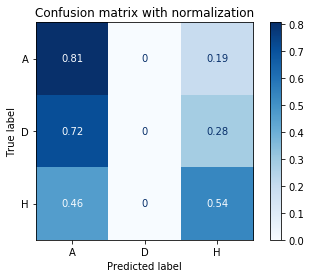

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV] C=0.01, gamma=1, kernel=linear ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=0.01, gamma=1, kernel=linear, total=   3.5s
[CV] C=0.01, gamma=1, kernel=linear ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ................... C=0.01, gamma=1, kernel=linear, total=   3.5s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ................... C=0.01, gamma=1, kernel=linear, total=   3.4s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ................... C=0.01, gamma=1, kernel=linear, total=   3.1s
[CV] C=0.01, gamma=1, kernel=linear ..................................
[CV] ................... C=0.01, gamma=1, kernel=linear, total=   2.8s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.4s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.4s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] ...................... C=0.01, gamma=1, kernel=rbf, total=   0.4s
[CV] C=0.01, gamma=1, kernel=rbf .....................................
[CV] .

[CV] .............. C=0.01, gamma=0.001, kernel=sigmoid, total=   0.2s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................
[CV] .............. C=0.01, gamma=0.0001, kernel=linear, total=   3.4s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................
[CV] .............. C=0.01, gamma=0.0001, kernel=linear, total=   3.6s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................
[CV] .............. C=0.01, gamma=0.0001, kernel=linear, total=   3.3s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................
[CV] .............. C=0.01, gamma=0.0001, kernel=linear, total=   3.1s
[CV] C=0.01, gamma=0.0001, kernel=linear .............................
[CV] .............. C=0.01, gamma=0.0001, kernel=linear, total=   2.8s
[CV] C=0.01, gamma=0.0001, kernel=rbf ................................
[CV] ................. C=0.01, gamma=0.0001, kernel=rbf, total=   0.4s
[CV] C=0.01, gamma=0.0001, kernel=rbf ................................
[CV] .

[CV] ................ C=0.1, gamma=0.01, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV] ................ C=0.1, gamma=0.01, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=0.01, kernel=sigmoid ...............................
[CV] ................ C=0.1, gamma=0.01, kernel=sigmoid, total=   0.2s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ................ C=0.1, gamma=0.001, kernel=linear, total=   8.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ................ C=0.1, gamma=0.001, kernel=linear, total=   8.6s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ................ C=0.1, gamma=0.001, kernel=linear, total=   8.7s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] ................ C=0.1, gamma=0.001, kernel=linear, total=   8.1s
[CV] C=0.1, gamma=0.001, kernel=linear ...............................
[CV] .

[CV] ................... C=1, gamma=0.1, kernel=sigmoid, total=   0.2s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ................... C=1, gamma=0.1, kernel=sigmoid, total=   0.3s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ................... C=1, gamma=0.1, kernel=sigmoid, total=   0.3s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ................... C=1, gamma=0.1, kernel=sigmoid, total=   0.2s
[CV] C=1, gamma=0.1, kernel=sigmoid ..................................
[CV] ................... C=1, gamma=0.1, kernel=sigmoid, total=   0.2s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=  13.1s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ................... C=1, gamma=0.01, kernel=linear, total=  13.3s
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] .

[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.6s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.6s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.3s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=10, gamma=1, kernel=sigmoid ...................................
[CV] .................... C=10, gamma=1, kernel=sigmoid, total=   0.2s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] .

In [ ]:
from team_ratings import Ratings

data, test = format_data('epl-training.csv','epl-test.csv','data_updated.csv')
ratings = Ratings(data)
ratings_data = ratings.result
ratings_history = ratings.rating
training_data = pd.concat(
    [data, ratings_data], axis=1, ignore_index=False)
training_data.to_csv('./COMP0036_EPL_Prediction/COMP0036_Brief/Data.csv')
ratings_history.to_csv('./COMP0036_EPL_Prediction/COMP0036_Brief/Data_2.csv')
ratings_data = load_file('Data.csv')
ratings_data = ratings_data[['HomeRatings','AwayRatings']]
ratings_history = load_file('Data_2.csv')
print(ratings_history)
selected_features = non_shot_feature_selection(data, ratings_data)
print(selected_features)
pred_data = extract_test_data(test, selected_features, ratings_data, ratings_history)

from models_parser_2 import Compare

models_comparison_obj = Compare(pd.concat([data,ratings_data],axis=1)[selected_features],data['FTR'])

from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
"""
Final Prediction to be completed
"""
best_model = models_comparison_obj.best_model
print(pred_data)
if models_comparison_obj.best_idx == 4:
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)
    best_model.model.fit(pd.concat([data, ratings_data], axis=1)[selected_features], to_categorical(
        data['FTR'])[:, [1, 2, 3]], batch_size=64, verbose=0, epochs=60, callbacks=[es])
    y_r = best_model.model.predict(pred_data)
else:
    best_model.fit(pd.concat([data, ratings_data], axis=1)[selected_features], data['FTR'])
    y_r = best_model.predict(pred_data)

print('The final prediction is:')
print(y_r)
result = pd.DataFrame({'FTR_Predicted': y_r})
print(result)
result = result['FTR_Predicted'].map({1: 'H', 2: 'D', 3: 'A'})
final_team = load_file('epl-test.csv')
print(final_team)
final = pd.concat([final_team, result], axis=1)
print(final)
final.to_csv('./COMP0036_EPL_Prediction/COMP0036_Brief/Prediction.csv')